In [109]:
# Import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re

In [2]:
dir = '/users/eva/Documents/Data_Science/Blog-Sentiment-Analysis/'

In [3]:
blogdata = pd.read_csv(dir + 'data/blogtext.csv')

In [4]:
blogdata.columns

Index(['id', 'gender', 'age', 'topic', 'sign', 'date', 'text'], dtype='object')

In [5]:
newcolumns = ['id', 'gender', 'age', 'industry', 'sign', 'date', 'text']
blogdata.columns = newcolumns
blogdata.head(3)

,id,gender,age,industry,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...


## Overview

In [8]:
blogdata_per_blogger = blogdata.groupby('id')

In [10]:
blogdata_per_blogger['gender'].value_counts()

id       gender
5114     male       197
7596     male        14
8173     male      1007
8349     male        70
9289     male        89
9470     male       360
11253    male         7
11762    female      20
15365    female     844
17944    female     128
21828    male        69
23166    female       1
23191    female       5
23676    male        12
24336    male       849
26357    male        41
27603    male        52
28417    female      73
28451    male        13
40964    female       5
46465    male        19
47519    male       179
48428    female       5
48923    female     128
49663    male      1252
61176    male         3
63420    male        26
64145    male       204
66895    female      18
67459    male        27
                   ... 
4330772  female       3
4331205  male         1
4331261  male         4
4331320  male         6
4331590  female       1
4331863  male         2
4332271  male         1
4332352  male         3
4332599  female       1
4333053  female       1


In [13]:
len(blogdata)

681284

In [15]:
len(blogdata.id.value_counts())

19320

In [11]:
per_blogger = blogdata.drop_duplicates("id")

In [12]:
len(per_blogger)

19320

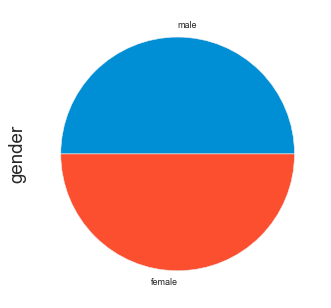

In [107]:
per_blogger.gender.value_counts().plot(kind="pie")

In [25]:
per_blogger.gender.value_counts(normalize=True)

male      0.5
female    0.5
Name: gender, dtype: float64

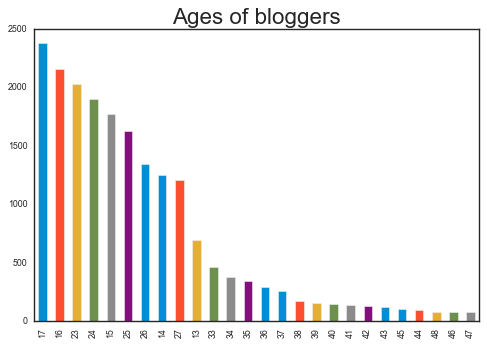

In [108]:
per_blogger.age.value_counts().plot(kind='bar',title='Ages of bloggers')

In [24]:
per_blogger.age.describe()

count    19320.000000
mean        22.833799
std          7.975490
min         13.000000
25%         16.000000
50%         23.000000
75%         26.000000
max         48.000000
Name: age, dtype: float64

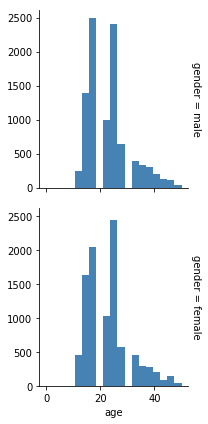

In [60]:
g = sns.FacetGrid(per_blogger, row="gender", margin_titles=True)
bins = np.linspace(0, 50, 20)
g.map(plt.hist, "age", color="steelblue", bins=bins)

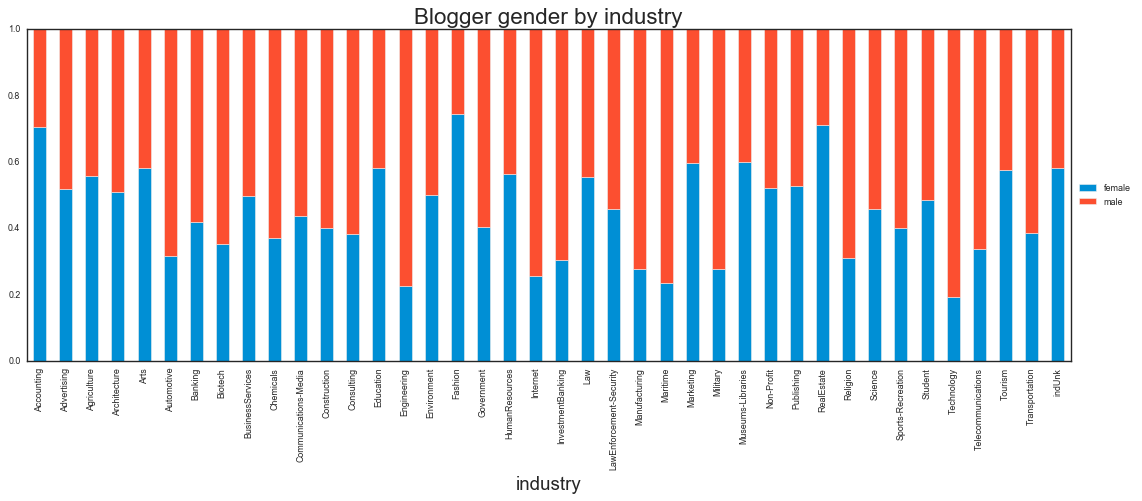

In [106]:
plt.style.use('seaborn-white')
industry_by_gender = per_blogger.groupby('industry').gender.value_counts(normalize=True)
industry_by_gender.unstack(level=1).plot.bar(figsize=(15,5), stacked=True, title="Blogger gender by industry")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

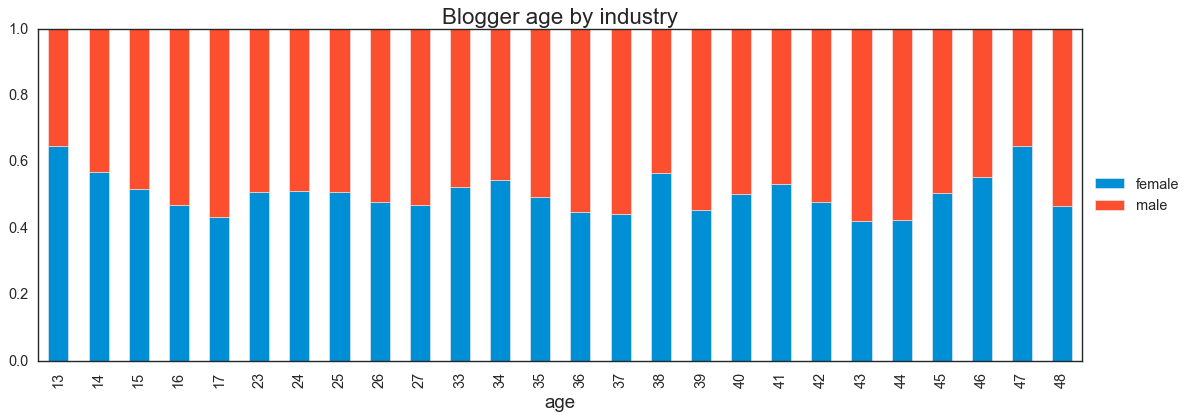

In [100]:
age_by_gender = per_blogger.groupby('age').gender.value_counts(normalize=True)
age_by_gender.unstack(level=1).plot.bar(figsize=(15,5), stacked=True, title="Blogger age by industry")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [80]:
print(plt.style.available)

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


# Data analysis
### Goals of my analysis
## Data analysis: Word frequencies
### Methods

## Data analysis: Topic clustering
I would like to look at what topics are discussed in different blogs, and whether those topics vary according to demographic group. I imagine the topics will be have clear differences when grouped by blogger industry, though even within industry blogs may vary widely - just because two people both work in "Banking" does not mean they both blog about banking.
### Methods
I have absolutely no interest in going through all or even a portion of the 681,000 blogs in this dataset and hand-labelling them for topics. So, supervised learning is not going to work here. I am going to try my hand at unsupervised learning. Specifically, I am going to try Latent Dirichlet allocation (LDA). LDA performs topic detection on large, unlabelled document sets. In order to use LDA, I need to convert the texts to vectors using a count vectorizer. 

I learned this model from the DataCamp project ["The Hottest Topics in Machine Learning"](https://projects.datacamp.com/projects/158). I edited the code in that tutorial to fit my own data.
### Preprocessing the data
First, I'm going to remove punctuation and lowercase all blog texts. Then, I will convert the blog texts into vectors.

In [117]:
print(blogdata['text'].head())

0               Info has been found (+/- 100 pages,...
1               These are the team members:   Drewe...
2               In het kader van kernfusie op aarde...
3                     testing!!!  testing!!!          
4                 Thanks to Yahoo!'s Toolbar I can ...
Name: text, dtype: object


In [114]:
from string import punctuation
print(punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [120]:
# Remove punctuation
blogdata['text_processed'] = blogdata['text'].map(lambda x: re.sub('[!"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~]', '', x))

# Lowercase
blogdata['text_processed'] = blogdata['text_processed'].map(lambda x: x.lower())

# Remove extra white space. Not sure if it messes with the vectorization process in any way but just to be sure
blogdata['text_processed'] = blogdata['text_processed'].map(lambda x: ' '.join(x.split()))

print(blogdata['text_processed'].head())

0    info has been found 100 pages and 45 mb of pdf...
1    these are the team members drewes van der laag...
2    in het kader van kernfusie op aarde maak je ei...
3                                      testing testing
4    thanks to yahoos toolbar i can now capture the...
Name: text_processed, dtype: object


In [125]:
from sklearn.feature_extraction.text import CountVectorizer
# Create count vectorizer with English stop words
count_vectorizer = CountVectorizer(max_features=500, stop_words = "english")

In [126]:
blog_vec = count_vectorizer.fit_transform(blogdata['text_processed'])

In [127]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

# Picking number of topics and number of words
number_topics = 10
number_words = 5

lda = LDA(n_components=number_topics)
lda.fit(blog_vec)

print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

KeyboardInterrupt: 